# 1. Preparing Tool Box

In [2]:
import os
for dirname, _, filenames in os.walk('\pkbhx\data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

\pkbhx\data\pkbhx.csv


In [107]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from scipy.stats import normaltest, skew
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tpot import TPOTRegressor

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 2. Reading the Data

In [4]:
# Create a DataFrame
data = pd.read_csv('\pkbhx\data\pkbhx.csv', sep=';')

# 3. Data Cleaning and Pre-processing

In [5]:
# Is there any null values?
print(data.isnull().values.any())

False


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  993 non-null    object 
 1   pK_BHX  993 non-null    float64
dtypes: float64(1), object(1)
memory usage: 15.6+ KB


In [7]:
# There might be one or more valid SMILES that can represent one compound
# Generate Canonical SMILES
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

In [8]:
Canon_SMILES = canonical_smiles(data.SMILES)
# len(Canon_SMILES)

# Put the smiles in the dataframe
data['SMILES'] = Canon_SMILES

In [9]:
# Analyzing the duplicates
print(f'{data.duplicated().sum()} duplicated records in {len(data)} total records.\n',
      f'Resulting in {data.duplicated().sum()/len(data)*100:.1f}% of duplicated records.')

0 duplicated records in 993 total records.
 Resulting in 0.0% of duplicated records.


In [10]:
# The RDKit package calculates the molecular descriptors
# for all molecules using as input the SMILE representation.
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
rdkit_2d_desc = []
for k in range(len(data)):
  header = calc.GetDescriptorNames()
  d = calc.CalcDescriptors(Chem.MolFromSmiles(data.iloc[k, 0]))
  rdkit_2d_desc.append(d)

temp_df = pd.DataFrame(rdkit_2d_desc, columns=header)  

data = pd.concat([data, temp_df], axis=1)

In [158]:
print(data.isnull().values.any())

False


In [42]:
data[data.isnull().any(axis=1)]

,SMILES,pK_BHX,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
697,c1ccc(C[Se](Cc2ccccc2)=[O:1])cc1,3.30,11.990193,-1.770000,11.990193,0.731879,0.785197,277.225,263.113,278.020986,...,0,0,0,0,0,0,0,0,0,0
698,C[Se](C)=[O:1],3.43,9.652778,-1.291667,9.652778,1.291667,0.434580,125.029,118.981,125.958386,...,0,0,0,0,0,0,0,0,0,0
839,c1ccc(P(c2ccccc2)(c2ccccc2)=[Se:1])cc1,0.94,3.550556,-1.651435,3.550556,1.372593,0.507427,341.252,326.132,342.007658,...,0,0,0,0,0,0,0,0,0,0
847,c1ccc([As](c2ccccc2)(c2ccccc2)=[O:1])cc1,4.15,13.878819,-3.544896,13.878819,0.933356,0.675029,322.239,307.119,322.033887,...,0,0,0,0,0,0,0,0,0,0
903,C[Se:1]C,-0.01,2.187500,0.875000,2.187500,0.875000,0.403159,109.030,102.982,109.963471,...,0,0,0,0,0,0,0,0,0,0


In [11]:
header = list(data.columns)

si = SimpleImputer(missing_values=np.nan, strategy='mean')
si = si.fit(data.drop(columns='SMILES'))

data_si = pd.DataFrame(si.transform(data.drop(columns='SMILES')))

data = pd.concat([data['SMILES'], data_si], axis=1)
data.columns = header

In [159]:
print(data.isnull().values.any())

False


In [12]:
data.drop(columns=['SMILES'], inplace=True)

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Columns: 209 entries, pK_BHX to fr_urea
dtypes: float64(209)
memory usage: 1.6 MB


In [101]:
data.head(5)

,pK_BHX,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.90,10.605370,0.058426,10.605370,0.058426,0.523744,121.139,114.083,121.052764,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.78,5.006944,0.888889,5.006944,0.888889,0.434057,87.122,78.050,87.068414,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.67,3.263889,1.212963,3.263889,1.212963,0.473722,103.190,94.118,103.045570,36.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.10,3.185185,1.166667,3.185185,1.166667,0.457255,89.163,82.107,89.029920,30.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.56,5.098194,0.913194,5.098194,0.913194,0.423889,101.149,90.061,101.084064,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Análise

In [17]:
features = []
for col in data.columns:
    features.append(col)

In [19]:
features

['pK_BHX',
 'MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VS

In [20]:
features.remove('pK_BHX')

In [50]:
target = 'pK_BHX'

In [54]:
print(f'{data["pK_BHX"].mean():.3f}')

1.146


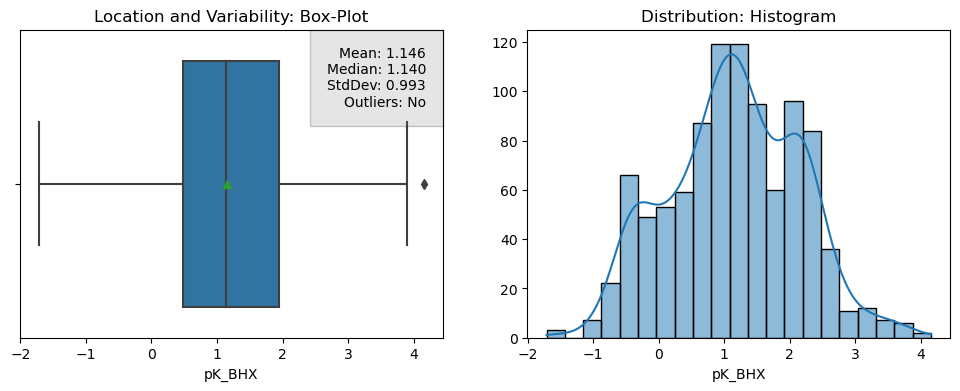

In [69]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

# Boxplot
sns.boxplot(data=data, x=data["pK_BHX"], ax=ax[0], showmeans=True)
ax[0].set_title('Location and Variability: Box-Plot')

# Check outliers
q1 = data["pK_BHX"].quantile(0.25)
q3 = data["pK_BHX"].quantile(0.75)
iqr = q3 - q1
outliers = (data["pK_BHX"][(q1-1.5*iqr <= data["pK_BHX"]) | data["pK_BHX"] >= q3+1.5*iqr])

if outliers.empty:
    has_outliers = 'No'
else:
    has_outliers = 'Yes'

# Presenting the stats
ax[0].annotate(text=f'Mean: {data["pK_BHX"].mean():.3f}\n'
                    f'Median: {data["pK_BHX"].median():.3f}\n'
                    f'StdDev: {data["pK_BHX"].std():.3f}\n'
                    f'Outliers: {has_outliers}',
                    xy=(1,1), xytext=(-12,-12), xycoords='axes fraction', textcoords='offset points', ha='right', va='top', bbox=dict(facecolor='grey', alpha=0.2, pad=12))

# Histogram
sns.histplot(data=data, x=data['pK_BHX'], ax=ax[1], kde=True)
ax[1].set_title('Distribution: Histogram')
ax[1].yaxis.label.set_visible(False)

# Normality stats
_, pvalue = normaltest(data['pK_BHX'])
skewness = skew(data['pK_BHX'])

plt.show()

In [13]:
data_y = data['pK_BHX']
data_X = data.drop(columns=['pK_BHX'])

In [14]:
data_X.shape

(993, 208)

# Select subsets of features based on their relationship with the target

In [15]:
from sklearn.feature_selection import VarianceThreshold

header = list(data_X.columns)

vt = VarianceThreshold()
data_X = vt.fit_transform(data_X)

cols = vt.get_support(indices=True)

selected_features = []
for i in range(len(cols)):
    selected_features.append(header[cols[i]])

data_X = pd.DataFrame(data_X, columns=selected_features)



In [16]:
data_X.shape

(993, 186)

In [17]:
#find the correlated features
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr(method="pearson")
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i][j]) >= threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    dataset.drop(col_corr, axis=1, inplace=True)
    return dataset

In [18]:
data_X = correlation(data_X, 0.4)

In [19]:
data_X.shape

(993, 54)

In [115]:
# Split Data into Training (80%) and Test set (20%)

X_train, X_test, y_train, y_test = model_selection.train_test_split(data_X, data_y, test_size=0.2, random_state=0)

In [22]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

rmse = make_scorer(rmse, greater_is_better=False)

In [77]:
metrics = pd.DataFrame(index=['R**2', 'Mean Absolute Error (MAE)', 'Mean Square Error (MSE)', 'Root Mean Square Error (RMSE)'],
                       columns=['Dummy Regressor', 'Support Vector Machine', 'Nearest Neighbors', 'Light Gradient Boosting', 'Random Forest', 'TPOT'])

In [62]:
def gridsearch_hyper(model_name, estimator, parameter_grid):
  gs = GridSearchCV(estimator, parameter_grid, cv=5, scoring=rmse)

  gs.fit(X_train, y_train)
  
  y_pred = gs.predict(X_test)

  metrics.loc['R**2', model_name] = r2_score(y_test, y_pred)
  metrics.loc['Mean Absolute Error (MAE)', model_name] = mean_absolute_error(y_test, y_pred)
  metrics.loc['Mean Square Error (MSE)', model_name] = mean_squared_error(y_test, y_pred)
  metrics.loc['Root Mean Square Error (RMSE)', model_name] = mean_squared_error(y_test, y_pred, squared=False)

  print(f'Best parameters to {model_name}: {gs.best_params_}')

In [108]:
# Space of hyperparameters and estimators we want to search through.
model_name = ['Dummy Regressor', 'Support Vector Machine', 'Nearest Neighbors', 'Light Gradient Boosting', "Random Forest"]

parameter_grid_dr = {
    'estimator__strategy':['mean', 'median']
}

parameter_grid_svr = {
    'estimator__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'estimator__degree':[3, 4, 5],
    'estimator__gamma':['scale', 'auto'],
    'estimator__coef0':[0.1, 0.25, 0.5, 1.0, 3.0, 5.0],
    'estimator__C':[0.01, 0.1, 0.25, 0.5, 1.0, 3.0, 5.0]
}

parameter_grid_nn = {
    'estimator__n_neighbors':[5, 6, 8, 10],
    'estimator__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'estimator__weights':['uniform', 'distance']
}

parameter_grid_lgb = {
    'estimator__learning_rate':[0.001, 0.01, 0.1],
    'estimator__max_depth':[4, 6, 8, 10],
    'estimator__tree_learner':['serial', 'feature', 'data', 'voting']
}

parameter_grid_rf = {
    'estimator__n_estimators':[10, 25, 50, 100],
    'estimator__criterion':['squared_error', 'absolute_error'],
    'estimator__max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'estimator__max_features':['auto', 'sqrt', 'log2']
}

In [103]:
model_dr = DummyRegressor()

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', model_dr)])
gs_dr = gridsearch_hyper('Dummy Regressor', pipe, parameter_grid_dr)

Best parameters to Dummy Regressor: {'estimator__strategy': 'mean'}


In [111]:
model_svr = SVR()

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', model_svr)])
gs_svr = gridsearch_hyper('Support Vector Machine', pipe, parameter_grid_svr)

Best parameters to Support Vector Machine: {'estimator__C': 5.0, 'estimator__coef0': 0.1, 'estimator__degree': 3, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}


In [105]:
model_nn = KNeighborsRegressor()

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', model_nn)])
gs_nn = gridsearch_hyper('Nearest Neighbors', pipe, parameter_grid_nn)

Best parameters to Nearest Neighbors: {'estimator__algorithm': 'ball_tree', 'estimator__n_neighbors': 6, 'estimator__weights': 'distance'}


In [100]:
model_lgb = lgb.LGBMRegressor(random_state=0, verbosity=-1)

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', model_lgb)])
gs_lgb = gridsearch_hyper('Light Gradient Boosting', pipe, parameter_grid_lgb)

Best parameters to Light Gradient Boosting: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 6, 'estimator__tree_learner': 'serial'}


In [109]:
model_rf = RandomForestRegressor(random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', model_rf)])
gs_rf = gridsearch_hyper('Random Forest', pipe, parameter_grid_rf)

Best parameters to Random Forest: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 10, 'estimator__max_features': 'auto', 'estimator__n_estimators': 100}


In [23]:
tpot_regressor = TPOTRegressor(generations=5, population_size=500, scoring=rmse, n_jobs=-1, verbosity=2, random_state=0)
tpot_regressor.fit(X_train.values, y_train)
tpot_regressor.export('/pkbhx/data/tpot_exported_pipeline_g5_p500.py')

Optimization Progress:   0%|          | 0/3000 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.325683393911981

Generation 2 - Current best internal CV score: -0.3025050102919342

Generation 3 - Current best internal CV score: -0.3024629739209984

Generation 4 - Current best internal CV score: -0.29977505028631823

Generation 5 - Current best internal CV score: -0.29977505028631823

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=10, min_child_weight=4, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.4, verbosity=0)


In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Average CV score on the training set was: -0.29977505028631823
exported_pipeline = XGBRegressor(learning_rate=0.1, max_depth=10, min_child_weight=4,
                                    n_estimators=100, n_jobs=1, objective="reg:squarederror",
                                    subsample=0.4, random_state = 0, verbosity=0)

exported_pipeline.fit(X_train.values, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=1,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [113]:
y_hat = exported_pipeline.predict(X_test)
metrics.loc['R**2', 'TPOT'] = r2_score(y_test, y_hat)
metrics.loc['Mean Absolute Error (MAE)', 'TPOT'] = mean_absolute_error(y_test, y_hat)
metrics.loc['Mean Square Error (MSE)', 'TPOT'] = mean_squared_error(y_test, y_hat)
metrics.loc['Root Mean Square Error (RMSE)', 'TPOT'] = mean_squared_error(y_test, y_hat, squared=False)

In [114]:
metrics

,Dummy Regressor,Support Vector Machine,Nearest Neighbors,Light Gradient Boosting,Random Forest,TPOT
R**2,-0.005299,0.558066,0.451478,0.730985,0.731743,0.735088
Mean Absolute Error (MAE),0.732584,0.417171,0.451477,0.354296,0.349605,0.339945
Mean Square Error (MSE),0.850519,0.373892,0.464069,0.227597,0.226955,0.224125
Root Mean Square Error (RMSE),0.922236,0.611467,0.681226,0.477071,0.476398,0.473418


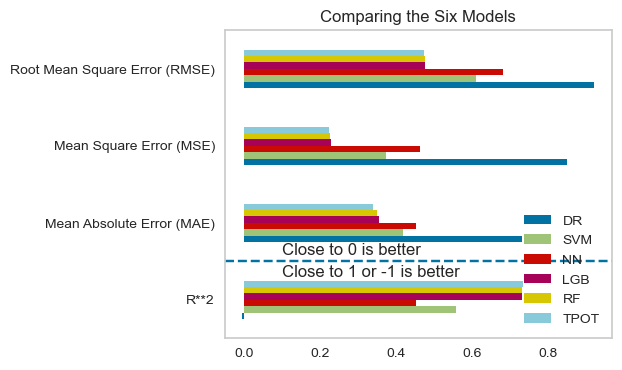

In [156]:
fig, ax = plt.subplots(figsize=(5, 4))
metrics.plot(kind='barh', ax=ax)
ax.grid()
ax.set_title('Comparing the Six Models')
plt.legend(['DR', 'SVM', 'NN', 'LGB', 'RF', 'TPOT'], loc=4, shadow=True)
plt.annotate('Close to 0 is better', xy=(0.1, 0.58))
plt.annotate('Close to 1 or -1 is better', xy=(0.1, 0.3))
plt.axhline(y=0.5, linestyle='--')
plt.show()

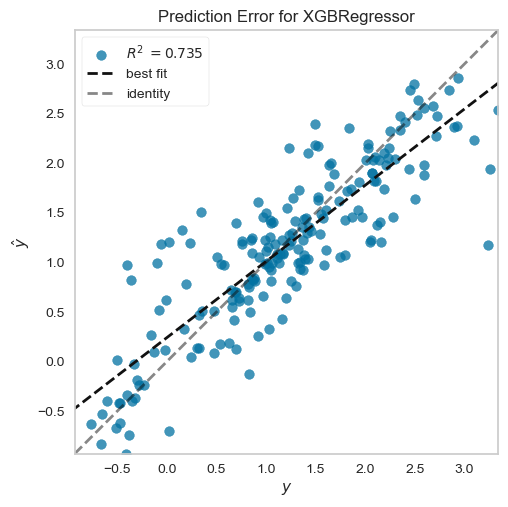

<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [164]:
from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer
pred_visualizer = PredictionError(exported_pipeline)

pred_visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
pred_visualizer.score(X_test, y_test)  # Evaluate the model on the test data
pred_visualizer.ax.grid(False)
pred_visualizer.show()                 # Finalize and render the figure

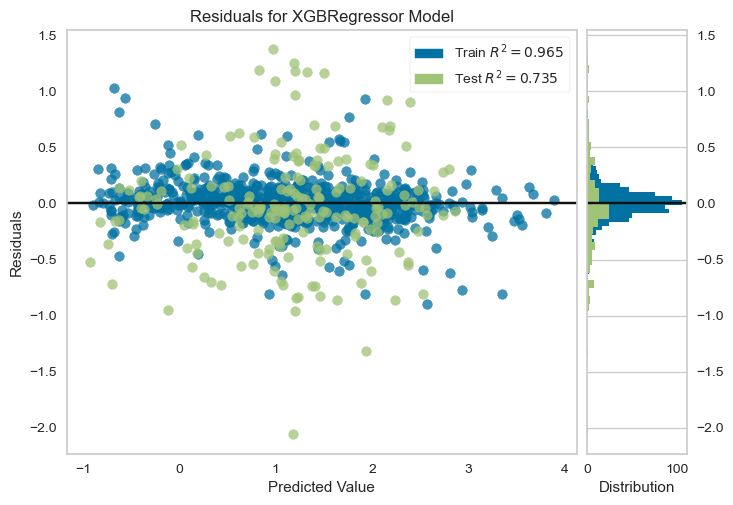

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [161]:
from yellowbrick.regressor import ResidualsPlot

res_visualizer = ResidualsPlot(exported_pipeline)

res_visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
res_visualizer.score(X_test, y_test)  # Evaluate the model on the test data
res_visualizer.ax.grid(False)
res_visualizer.show()  

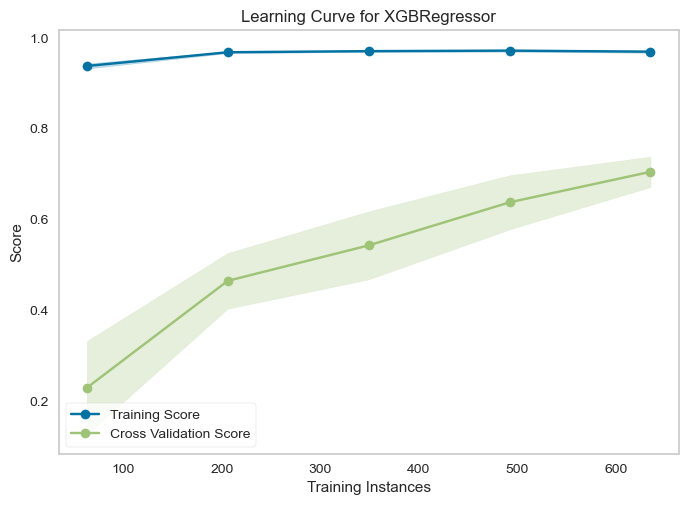

<AxesSubplot:title={'center':'Learning Curve for XGBRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [166]:
from yellowbrick.model_selection import LearningCurve

# Instantiate the regression model and visualizer
lea_visualizer = LearningCurve(exported_pipeline, scoring='r2')

lea_visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
lea_visualizer.ax.grid(False)
lea_visualizer.show()           # Finalize and render the figure